In [1]:
import pandas as pd
import os
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

# LeNet5 Train

In [2]:
os.getcwd()

'c:\\Users\\fvajana\\Documents\\Work\\thesis\\code'

In [3]:
path = "runs/LeNet5/train_logs.xlsx"
df = pd.read_excel(path, index_col=0)

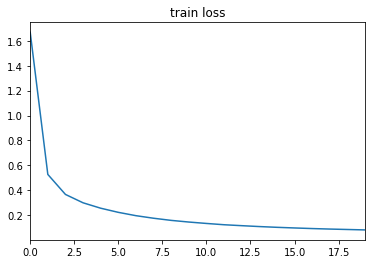

In [4]:
df['train loss'].plot(title='train loss')